<a href="https://colab.research.google.com/github/SSAditya12/my-projects/blob/main/VAE_auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch 1/15  avg loss per sample: 44.1499
Epoch 5/15  avg loss per sample: 33.6545
Epoch 10/15  avg loss per sample: 30.0859
Epoch 15/15  avg loss per sample: 28.9930


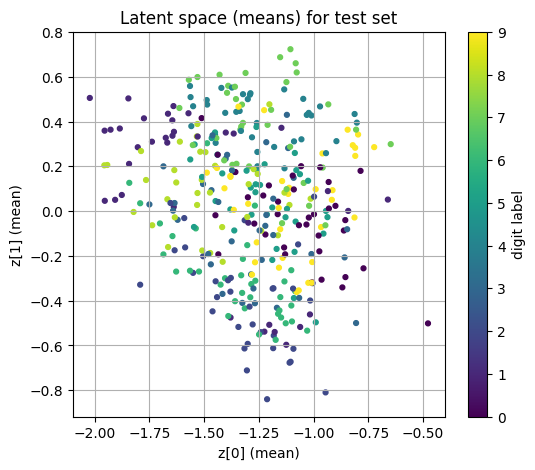

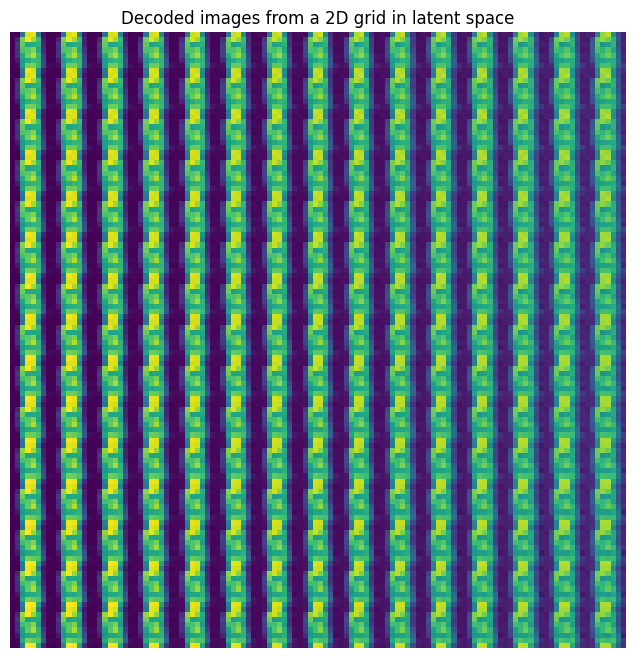

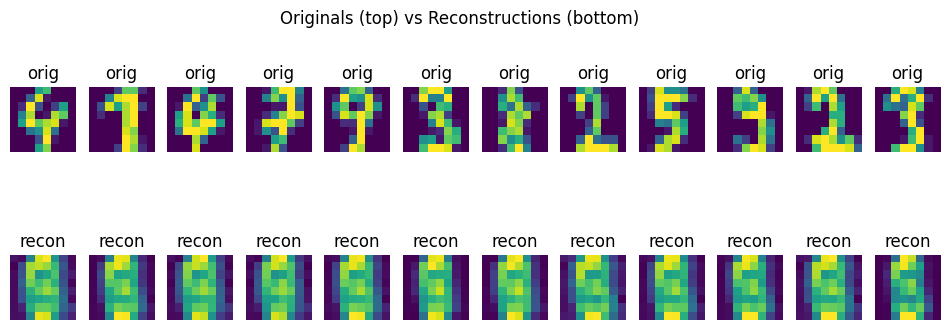

Finished: latent scatter, decoded grid, and reconstructions displayed.


In [ ]:
# vae_digits_visualize.py
# Trains a small VAE (2D latent) on sklearn digits and visualizes latent space & reconstructions.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------
# 1) Load the digits data
# ------------------------
digits = load_digits()
X = digits.images.astype("float32") / 16.0   # scale to [0,1]
y = digits.target
n_samples = X.shape[0]
X = X.reshape((n_samples, -1))  # flatten to (n_samples, 64)

# If you want MNIST instead, uncomment the following:
# from tensorflow.keras.datasets import mnist
# (x_tr, _), (x_te, _) = mnist.load_data()
# X = np.concatenate([x_tr, x_te]).astype("float32") / 255.0
# X = X.reshape((X.shape[0], -1)); y = np.zeros(X.shape[0])  # no labels used here

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t), batch_size=128, shuffle=True)

# ------------------------
# 2) VAE model (small)
# ------------------------
input_dim = X_train.shape[1]  # 64 for digits (8x8)
latent_dim = 2                # make latent 2D for visualization
hidden_dim = 64

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mean(h1), self.fc_logvar(h1)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc_out(h3))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    # BCE reconstruction + KL divergence
    bce = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

# ------------------------
# 3) Train (short run)
# ------------------------
epochs = 15   # increase for better reconstructions
model.train()
for epoch in range(1, epochs + 1):
    total_loss = 0.0
    for batch in train_loader:
        data = batch[0].to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0 or epoch == 1:
        avg = total_loss / len(X_train)
        print(f"Epoch {epoch}/{epochs}  avg loss per sample: {avg:.4f}")

# ------------------------
# 4) Visualizations
# ------------------------
model.eval()
with torch.no_grad():
    X_test_dev = X_test_t.to(device)
    recon_test, mu_test, logvar_test = model(X_test_dev)
    mu_np = mu_test.cpu().numpy()
    recon_np = recon_test.cpu().numpy()

# 4a) Latent-space scatter (means)
plt.figure(figsize=(6,5))
sc = plt.scatter(mu_np[:,0], mu_np[:,1], c=y_test, s=12)
plt.colorbar(sc, label="digit label")
plt.xlabel("z[0] (mean)")
plt.ylabel("z[1] (mean)")
plt.title("Latent space (means) for test set")
plt.grid(True)
plt.show()

# 4b) Grid of decoded images from a 2D latent grid
n = 15
# choose latent ranges from percentiles of the encoded means
z0_min, z0_max = np.percentile(mu_np[:,0], [2,98])
z1_min, z1_max = np.percentile(mu_np[:,1], [2,98])
z0 = np.linspace(z0_min, z0_max, n)
z1 = np.linspace(z1_min, z1_max, n)

figure = np.zeros((int(np.sqrt(input_dim)) * n, int(np.sqrt(input_dim)) * n))
img_size = int(np.sqrt(input_dim))  # 8 for digits
for i, yi in enumerate(z1[::-1]):  # reverse so top->bottom looks natural
    for j, xi in enumerate(z0):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        with torch.no_grad():
            x_dec = model.decode(z_sample).cpu().numpy()[0]
        figure[i * img_size: (i + 1) * img_size, j * img_size: (j + 1) * img_size] = x_dec.reshape(img_size, img_size)

plt.figure(figsize=(8,8))
plt.imshow(figure, interpolation="nearest")
plt.title("Decoded images from a 2D grid in latent space")
plt.axis("off")
plt.show()

# 4c) Originals vs reconstructions
n_show = 12
idxs = np.random.choice(len(X_test), n_show, replace=False)
plt.figure(figsize=(12,4))
for i in range(n_show):
    ax = plt.subplot(2, n_show, i + 1)
    plt.imshow(X_test[idxs[i]].reshape(img_size,img_size), interpolation="nearest")
    plt.title("orig")
    plt.axis("off")
    ax = plt.subplot(2, n_show, n_show + i + 1)
    plt.imshow(recon_np[idxs[i]].reshape(img_size,img_size), interpolation="nearest")
    plt.title("recon")
    plt.axis("off")
plt.suptitle("Originals (top) vs Reconstructions (bottom)")
plt.show()

print("Finished: latent scatter, decoded grid, and reconstructions displayed.")
